## Presentation

A notebook to process BCDI data using cdiutils package and PyNX phase retrieval

In [1]:
import os
import hdf5plugin # if data are too large
from xrayutilities import en2lam

from cdiutils.processing.pipeline import BcdiPipeline
from cdiutils.load.authorized_keys import get_parameters_from_notebook_variables

## Processing parameters

In [6]:
metadata = {
  'beamline_setup':
  'ID01BLISS',
  'scan': 14,
  'sample_name': 'Sample1_ParticlesMNOP',
  'experiment_file_path': '/data/id01/inhouse/experiment_data/2022/ch6347/id01/ch6347_id01.h5',
  'detector_data_path': None, # for ID01SPEC setup
  'edf_file_template': None, # for ID01SPEC setup
  'detector_name': 'mpxgaas',
  'flatfield_path': "/data/id01/inhouse/clatlan/experiments/ch6347/analysis/gaas_flatfield.npz",
  'dump_dir': None,
  'reconstruction_file': "mode.h5"
}

metadata["dump_dir"] = (
    '/data/id01/inhouse/clatlan/experiments/ch6347/2023s_analysis'
    f'/results/{metadata["sample_name"]}/S{metadata["scan"]}/'
)

preprocessing_output_shape = [150, 150]
energy = 19900
roi = [0, 516, 0, 516]
hkl = [1, 1, 1]
det_reference_voxel_method = "max"
det_reference_voxel = None
binning_along_axis0 = None

det_calib_parameters = {
  "cch1": 56.074854967362114, # direct beam position vertical 
  "cch2": 118.36821297645119, # horizontal
  "pwidth1": 5.5e-05,
  "pwidth2": 5.5e-05,
  "distance": 0.953935828966216,
  "tiltazimuth": 177.12335779627824,
  "tilt": 5.231672854863918,
  "detrot": -0.6923076923076923,
  "outerangle_offset": 0.0
}

voxel_size = 10
apodize = True
flip = False
isosurface = None

usetex = True
show = True
verbose = True
debug = True

# PyNX parameters
data = (
  metadata["dump_dir"]
  + f"S{metadata['scan']}_pynx_input_data.npz"
)

mask = (
  metadata["dump_dir"]
  + f"S{metadata['scan']}_pynx_input_mask.npz"
)

data2cxi = True
auto_center_resize = True

support_type = "square"
support_size = (40, 20, 40)
support = "auto"
support_threshold = "0.30, 0.40"
support_threshold_method = "rms"
support_only_shrink = False
support_update_period = 20
support_smooth_width_begin = 2
support_smooth_width_end = 1
support_post_expand = "1,-2,1"
psf = "pseudo-voigt,0.5,0.1,10"

nb_raar = 1000
nb_hio = 150
nb_er = 150
nb_ml = 10
nb_run = 25
nb_run_keep = 10

zero_mask = False
crop_output = 0
positivity = False
beta = 0.9
detwin = False

rebin = "1,1,1"
detector_distance = det_calib_parameters["distance"]
pixel_size_detector = 55e-6
wavelength = float(en2lam(energy) * 1e-10) # wavelength in meter

verbose = 100
output_format = "cxi"
live_plot = False
save_plot = True
mpi = "run"


# Load the parameters and parse them into the BcdiPipeline instance 
parameters = get_parameters_from_notebook_variables(dir(), globals())
bcdi_pipeline = BcdiPipeline(parameters=parameters)

### Preprocess the data: crop and center the data


********************************************************************************
*   [INFO] Proceeding to preprocessing using the cdiutils backend (scan 332)   *
********************************************************************************

The preprocessing output shape is: (91, 150, 150)
Method employed for the reference voxel determination is max
Shape before checking: (91, 150, 150)
Shape after checking: (86, 150, 150)
[INFO]

Max in the full detector frame at (48, 171, 145)
Max in the cropped
detector frame at (43, 75, 75)
The max corresponds to a d-spacing of 2.2531 A
and a lattice parameter of 3.9026 A

Com in the full detector frame at (48.74,
170.29, 145.02) (based on a (150, 150) max-centered bounding box)
Com in the
cropped detector frame at (43.74, 74.29, 75.02)
The com corresponds to a
d-spacing of 2.2527 A and a lattice parameter of 3.9018 A

The reference
q_lab_reference corresponds to a d-spacing of 2.2531 A and a lattice parameter
of 3.9026 A

[INFO] Dump directory

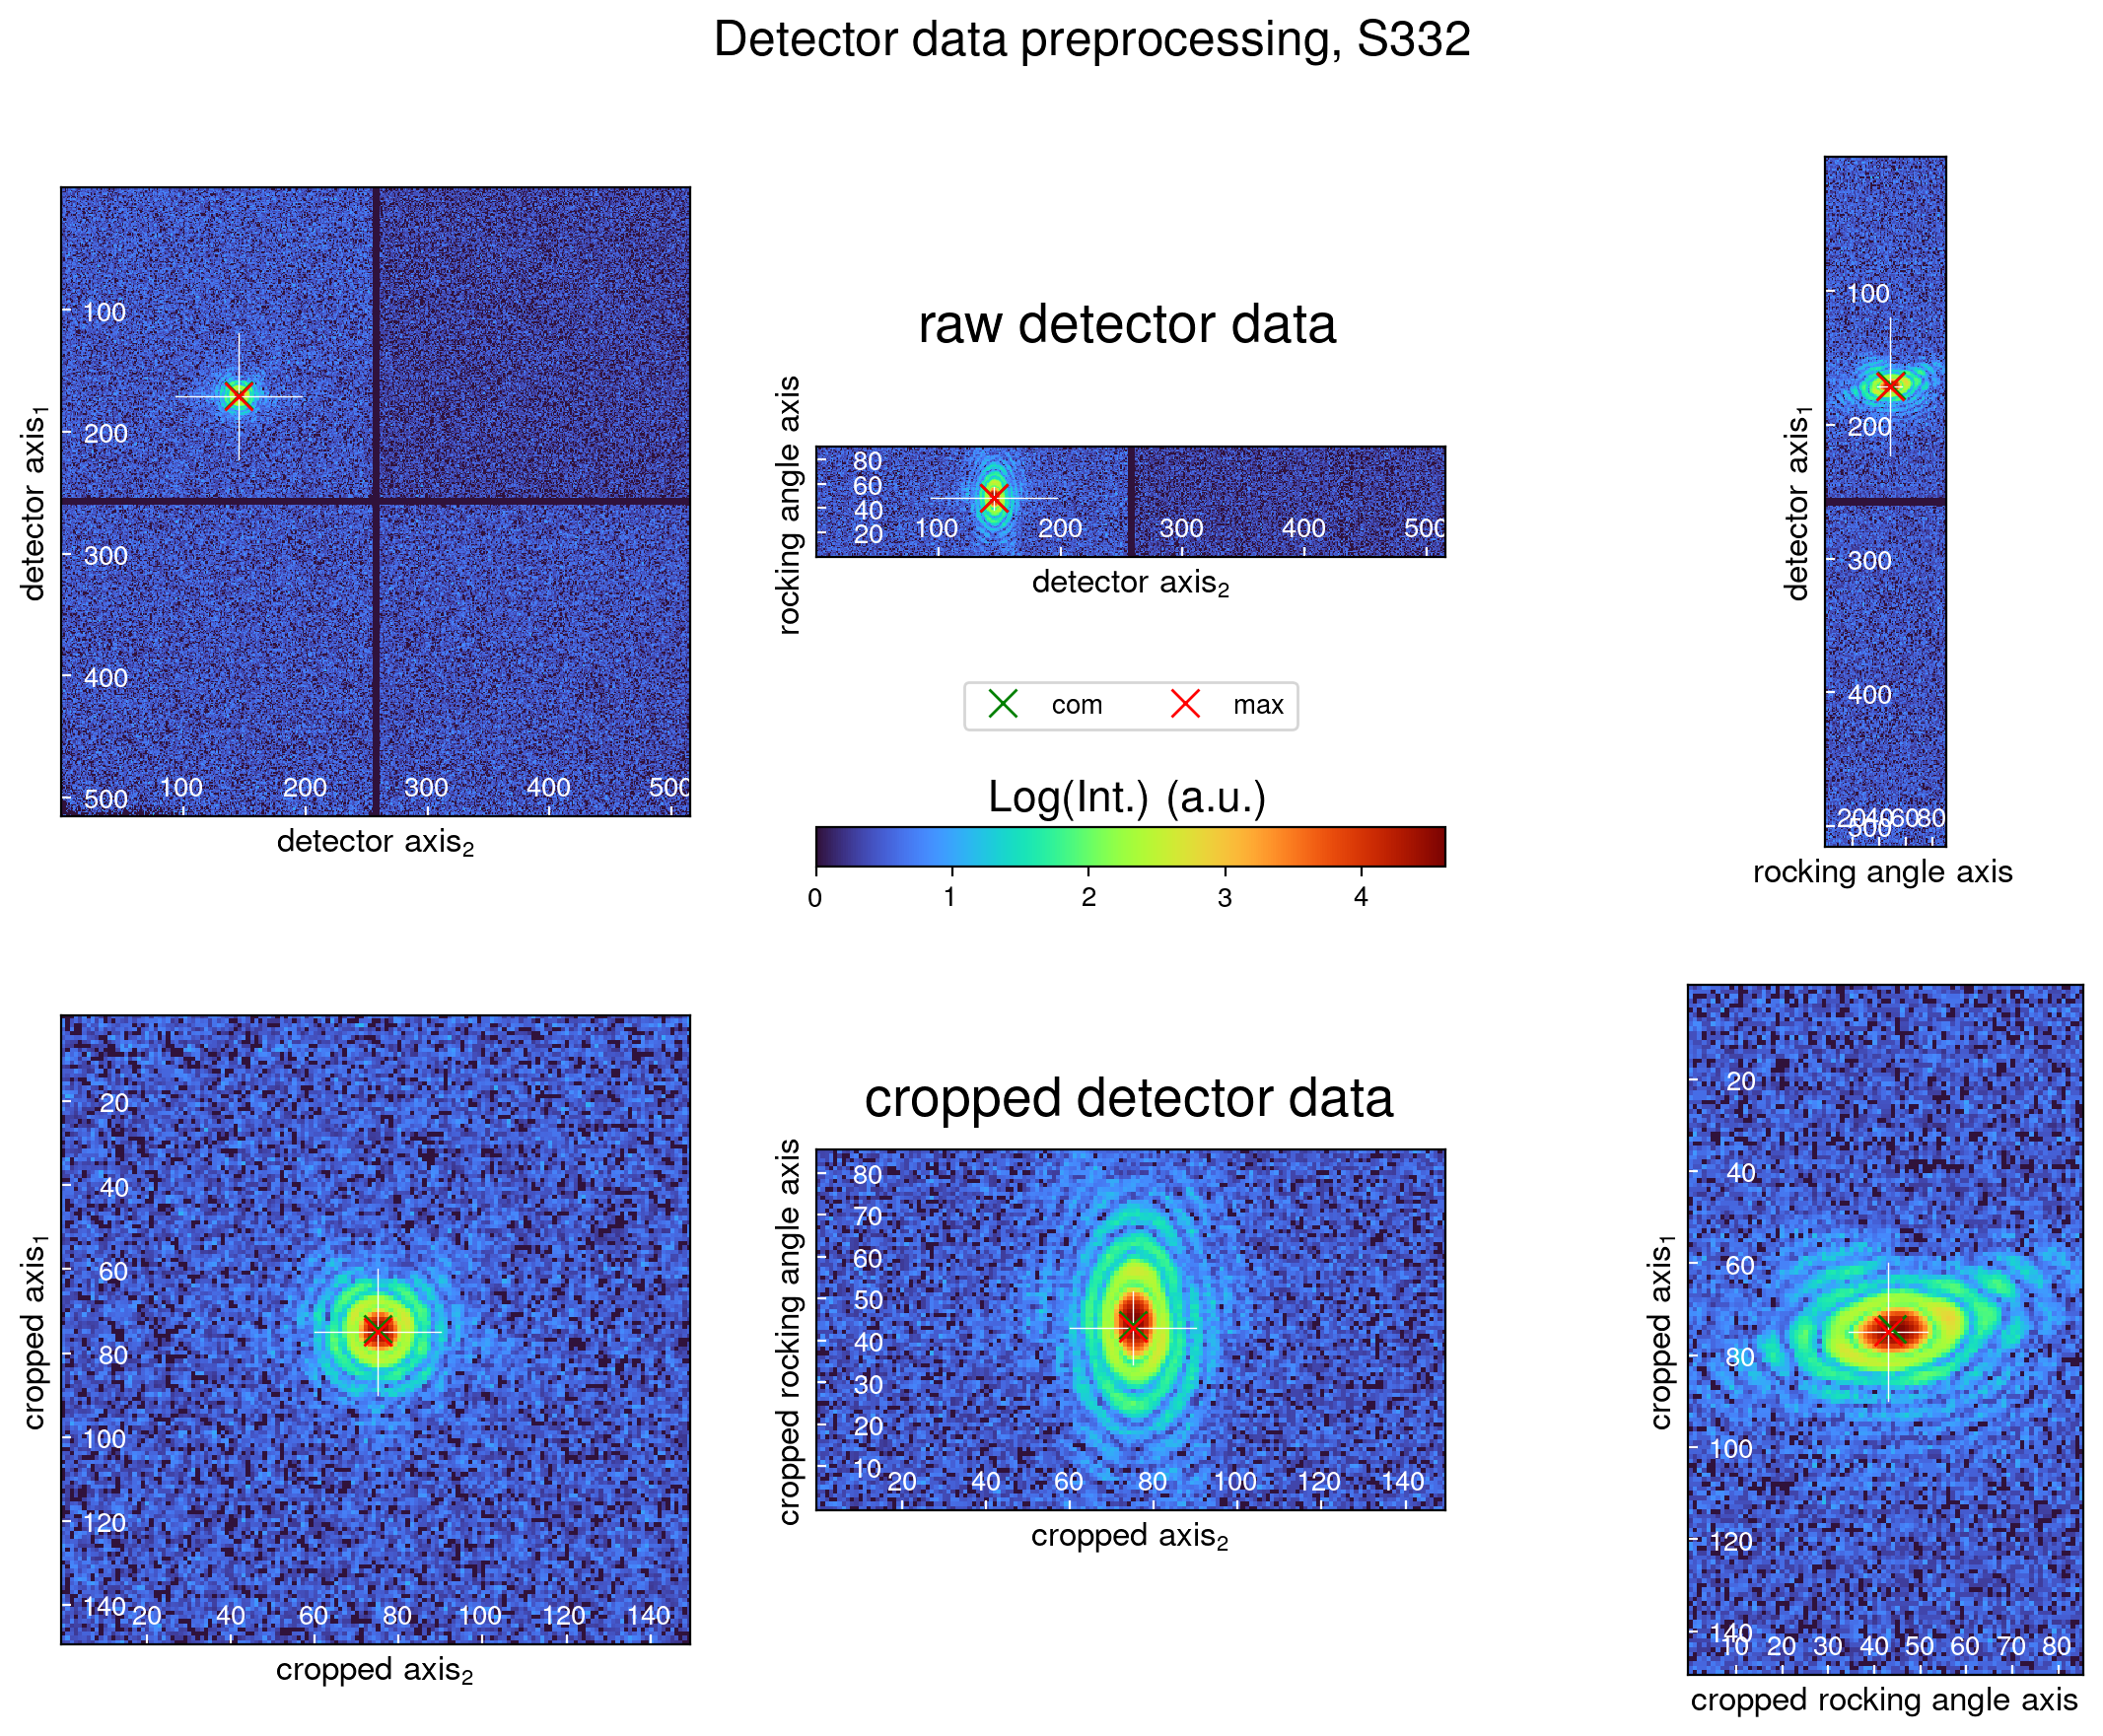


********************************************************************************
*Saving scan parameter file at the following location: /data/id01/inhouse/clatlan
/experiments/ch6347/2023s_analysis/results/Sample1_ParticlesMNOP/S332/*
********************************************************************************



In [92]:
bcdi_pipeline.preprocess()

### Run PyNX phase retrieval using ESRF's p9 GPUs

In [93]:
user = os.environ["USER"]
key_file_path = os.environ["HOME"] + "/.ssh/id_rsa"

print(
    f"Will use the user name '{user}' "
    f"and the private key file path: '{key_file_path}'"
)

bcdi_pipeline.phase_retrieval(
    machine="slurm-nice-devel",
    user=user,
    key_file_path=key_file_path,
    remove_last_results=True
)

Will use the user name 'atlan' and the private key file path: '/users/atlan/.ssh/id_rsa'

********************************************************************************
*             [INFO] Proceeding to PyNX phase retrieval (scan 332)             *
********************************************************************************

[INFO] Removing former results

Pynx slurm file template not provided, will take the default: /data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/processing/pynx-id01cdi_template.slurm
[INFO] Connected to slurm-nice-devel
Submitted batch job 5436575

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING

[INFO] process status: RUNNING
#  CDI Run: 1/25  support_threshold = 0.301

[INFO] process status: RUNNING
#  CDI Run: 1/25 

### Filter/sort the reconstructions and decompose them into one mode


In [94]:
bcdi_pipeline.find_best_candidates(nb_to_keep=5)
bcdi_pipeline.mode_decomposition()


********************************************************************************
*        [INFO] Finding the best candidates of the PyNX run. (scan 332)        *
********************************************************************************


[INFO] Candidates with the lowest mean_to_max will be saved.

[INFO] Opening file: S332_pynx_input_data-2023-02-09T14-29-15_Run0013_LLKf000.7298_LLK000.6628_SupportThreshold0.38926.cxi
[INFO] Opening file: S332_pynx_input_data-2023-02-09T14-29-14_Run0015_LLKf000.6982_LLK000.6615_SupportThreshold0.38053.cxi
[INFO] Opening file: S332_pynx_input_data-2023-02-09T14-29-21_Run0021_LLKf000.7178_LLK000.6607_SupportThreshold0.36975.cxi
[INFO] Opening file: S332_pynx_input_data-2023-02-09T14-29-08_Run0005_LLKf000.7141_LLK000.6513_SupportThreshold0.36048.cxi
[INFO] Opening file: S332_pynx_input_data-2023-02-09T14-29-08_Run0008_LLKf000.7035_LLK000.6616_SupportThreshold0.38364.cxi
[INFO] Opening file: S332_pynx_input_data-2023-02-09T14-28-58_Run0003_LLKf000

### Finally postprocess the data: orthogonalize, compute phase, dispacement, strain, dspacing...

(44.71633205504173, 72.08166027520866, 74.85923753665689) (90, 144, 150) (19.716332055041732, 71.08166027520866, 77.85923753665689)
[INFO] The shape of the reconstructed object is: (90, 144, 150)
The shape for a
safe centered cropping is: (90, 144, 150)
[INFO] Voxel size in the direct lab frame provided by user: 10 nm
[INFO] the extent in the target space of a regular grid defined in the original space with a shape of (90, 144, 150) is (124, 151, 146)
[INFO] Voxel size in the direct lab space due to the orthognolization process [21.53270238  7.20831004  8.12313537]
[INFO] the extent in the target space of a regular grid defined in the original space with a shape of (90, 144, 150) is (192, 112, 136)
[INFO] Voxel size finally used is: [10 10 10] nm in the CXI convention
[PROCESSING] Apodizing the complex array:done.
[PROCESSING] Finding an isosurface estimate based on the reconstructed Bragg
electron density histogram:done.
[INFO] isosurface estimated at 0.7822351919497212
[INFO] The the

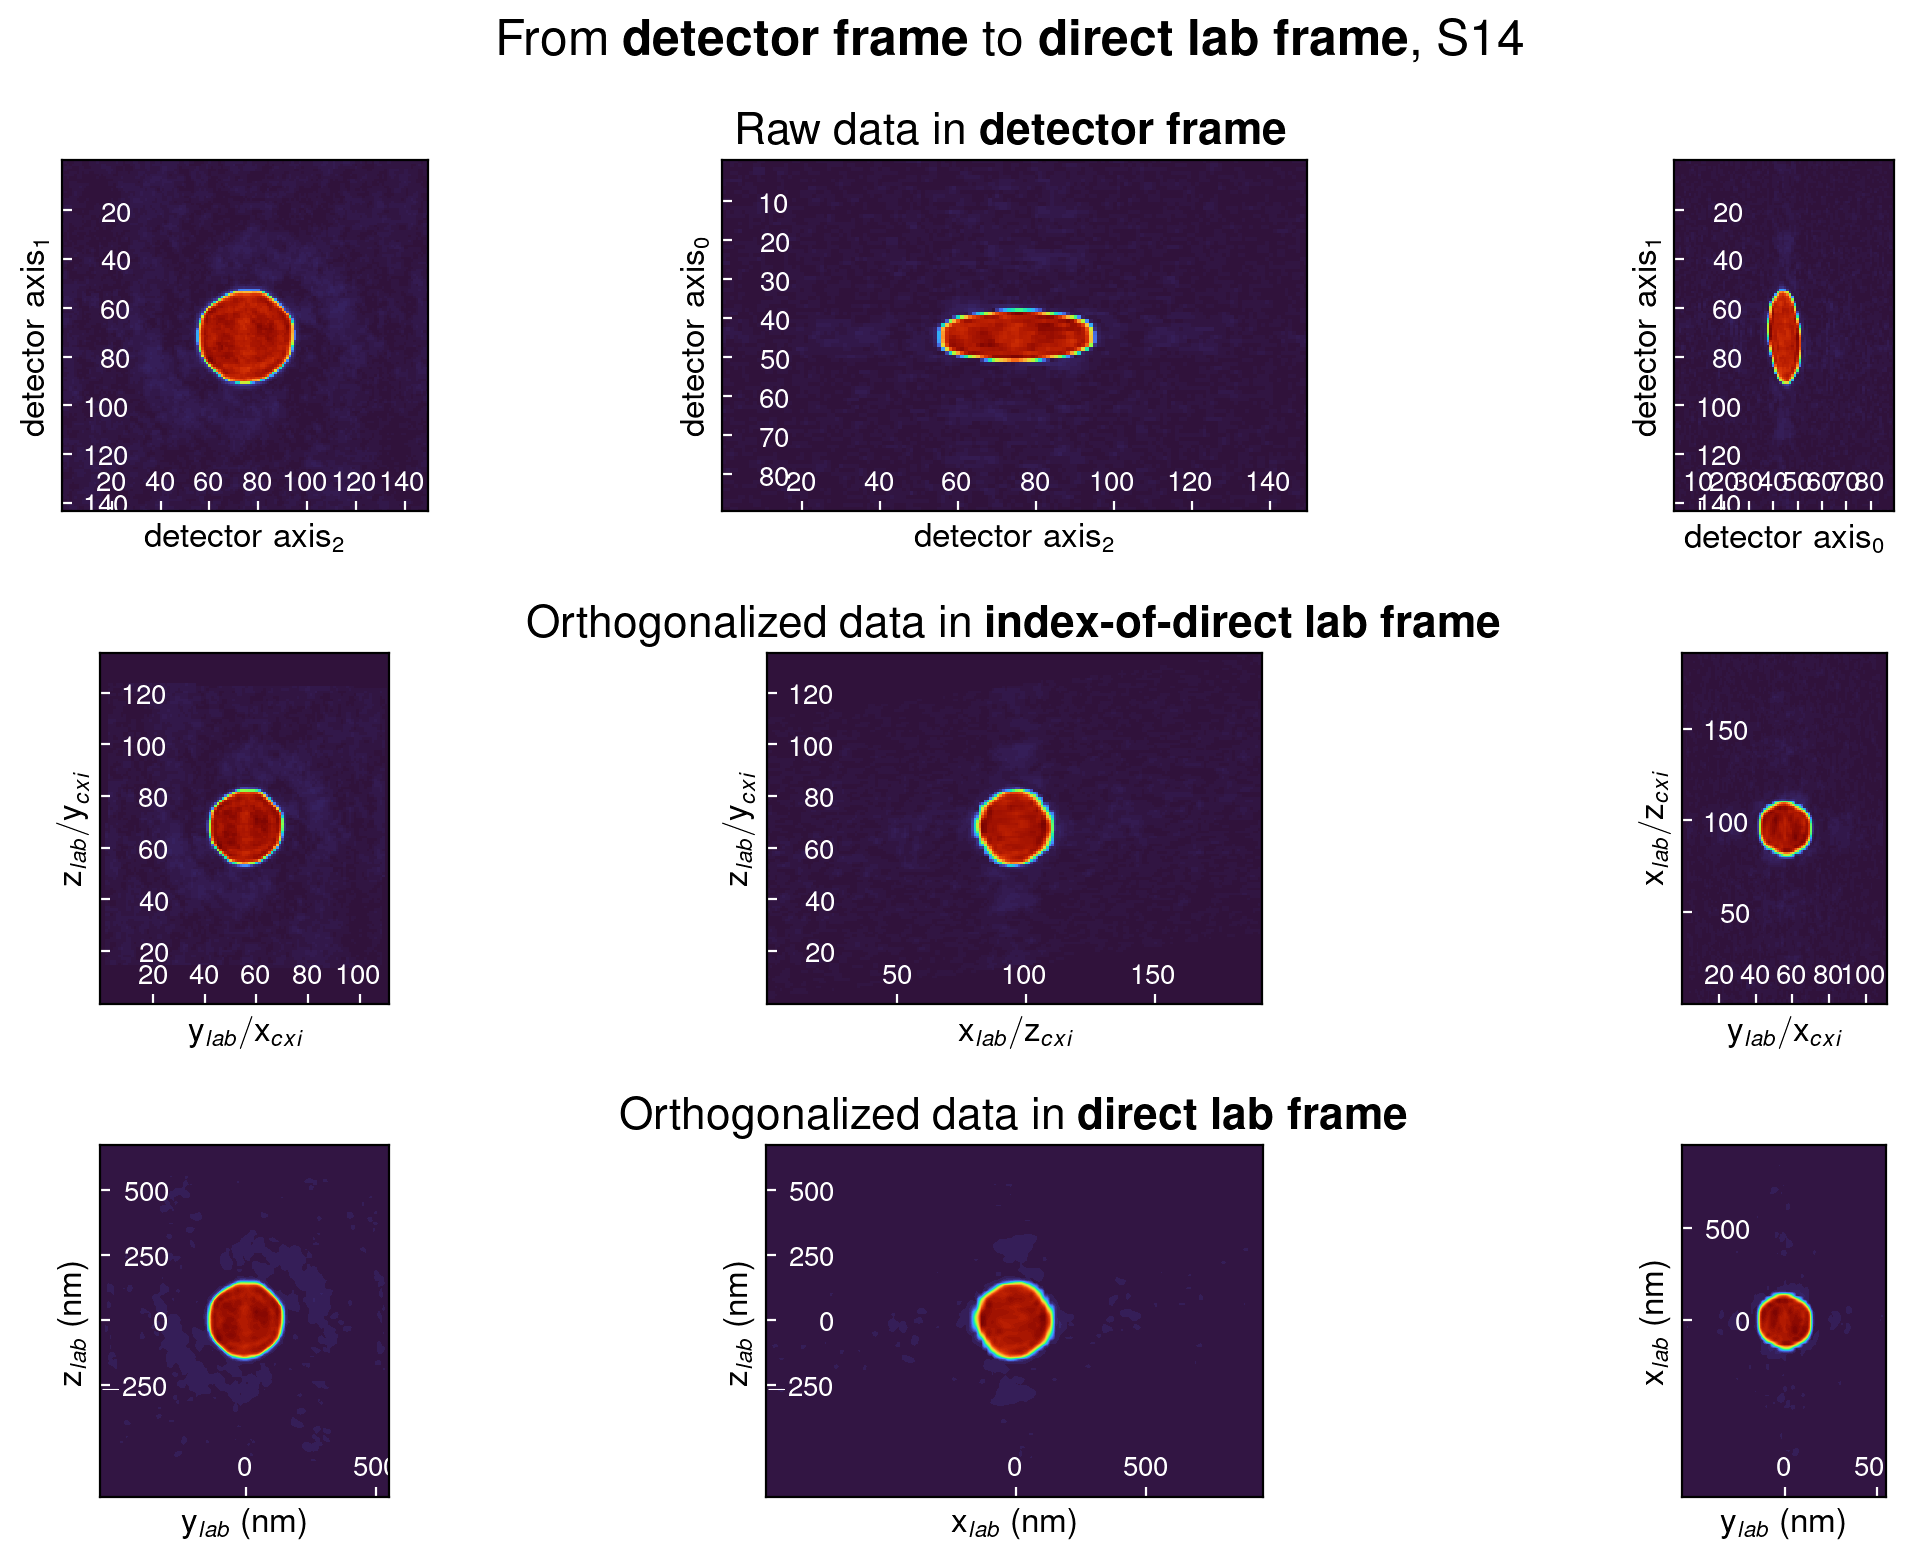

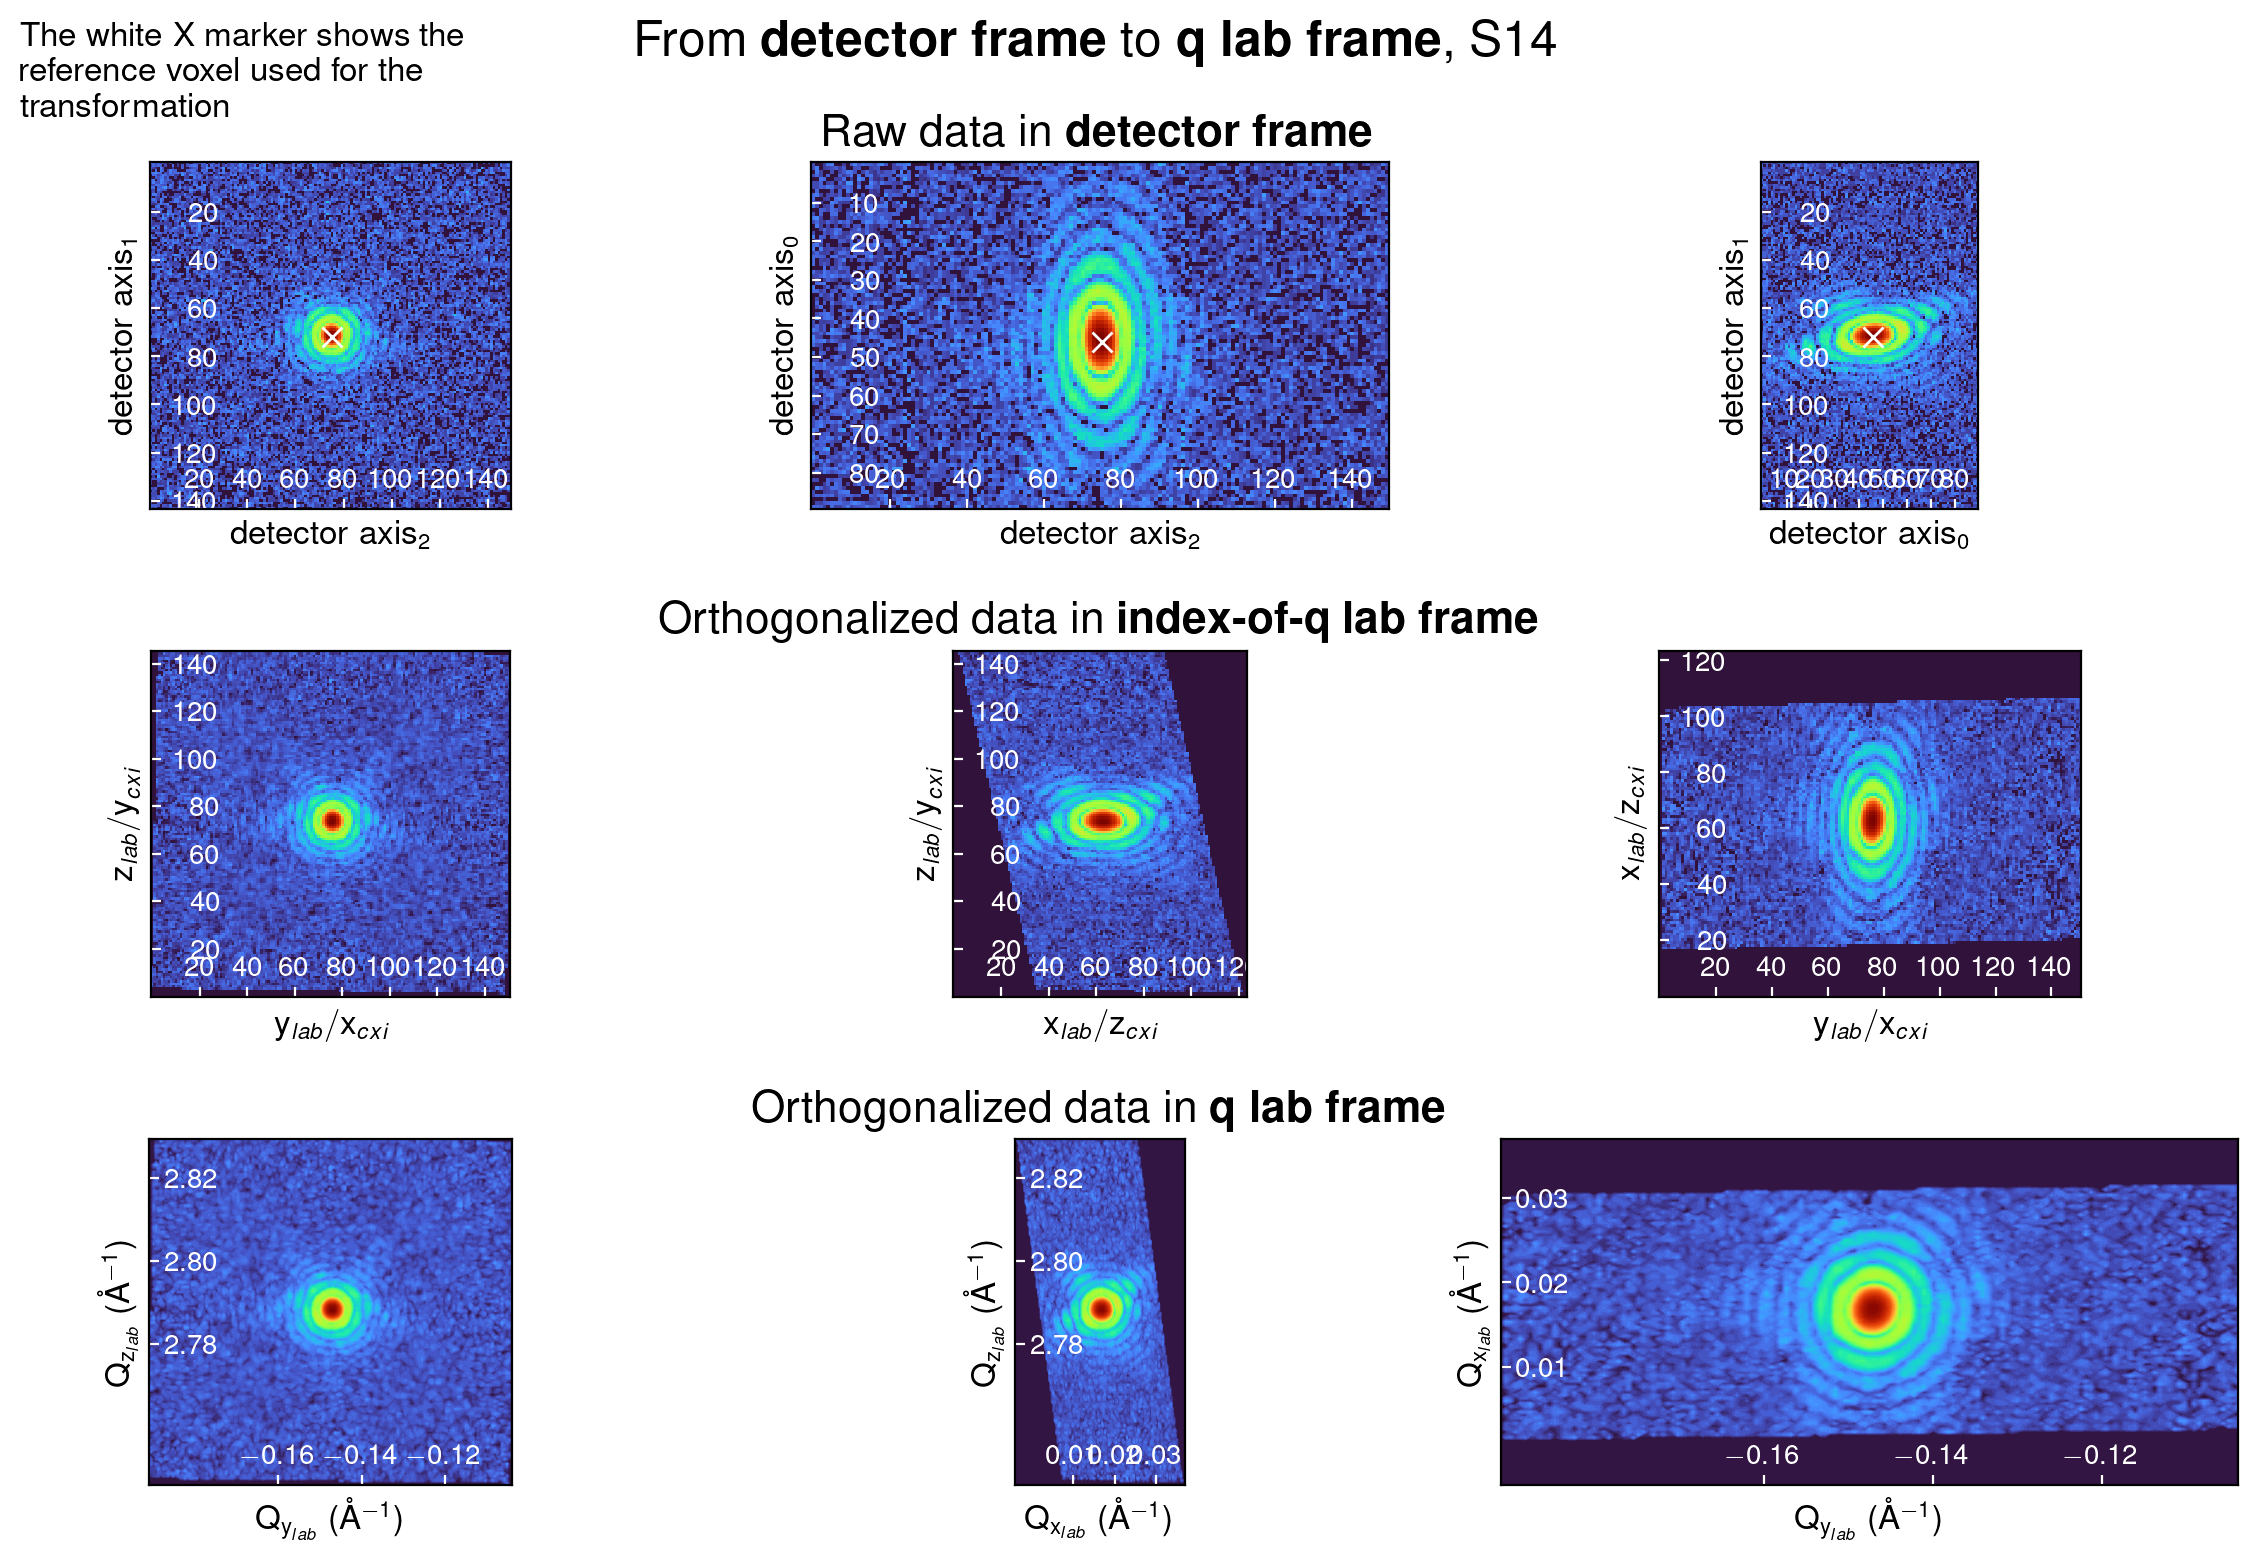

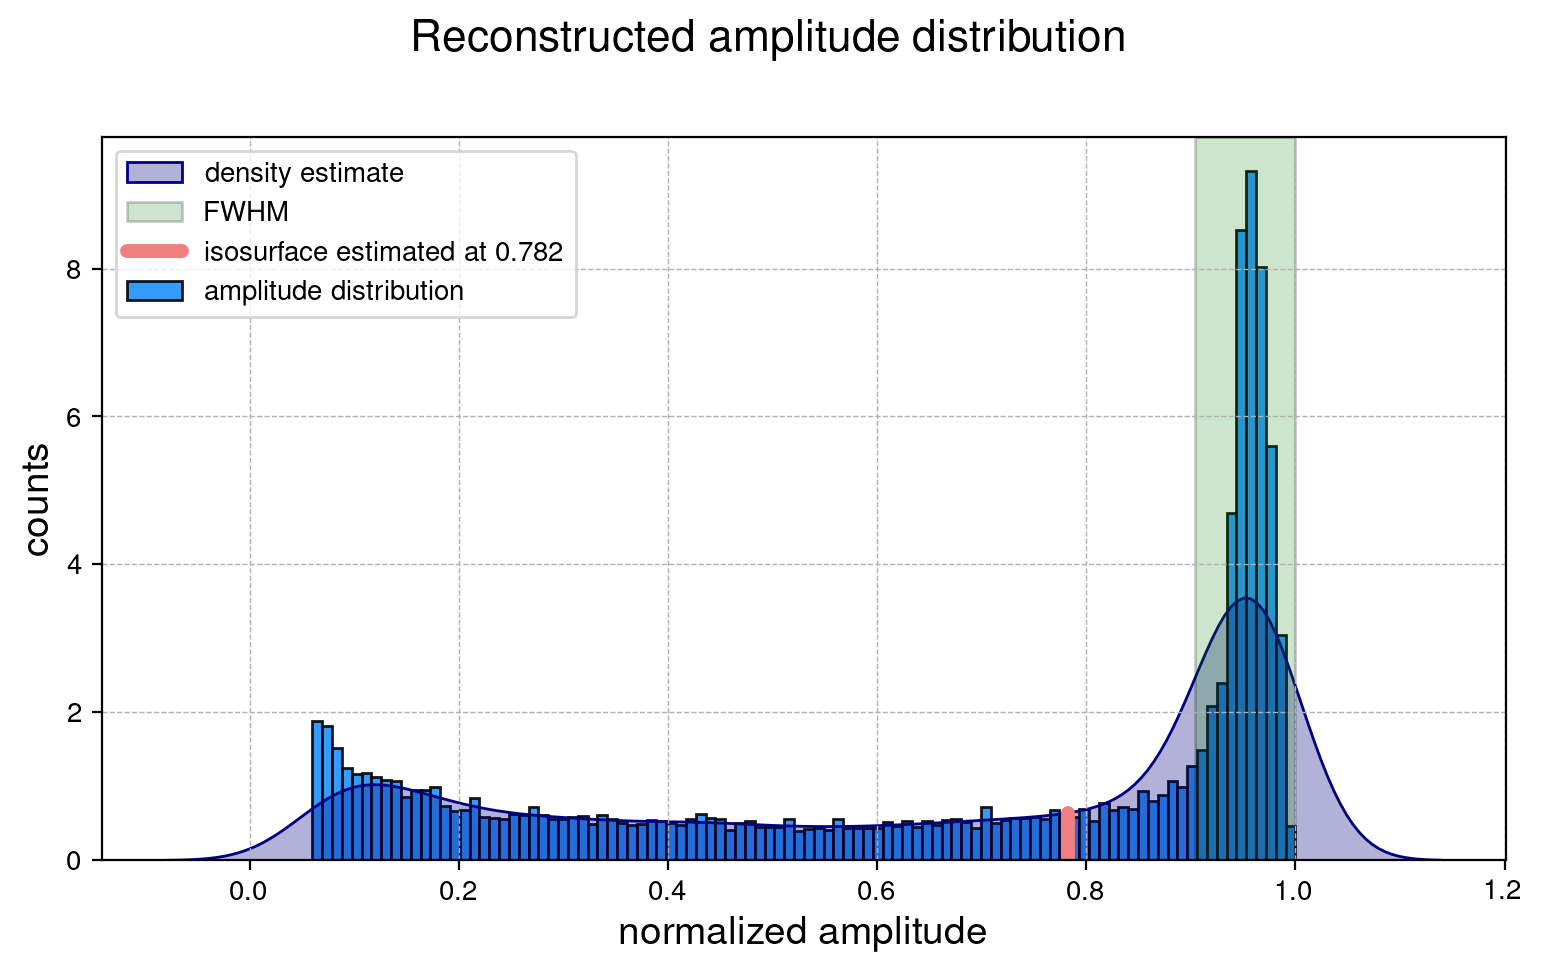

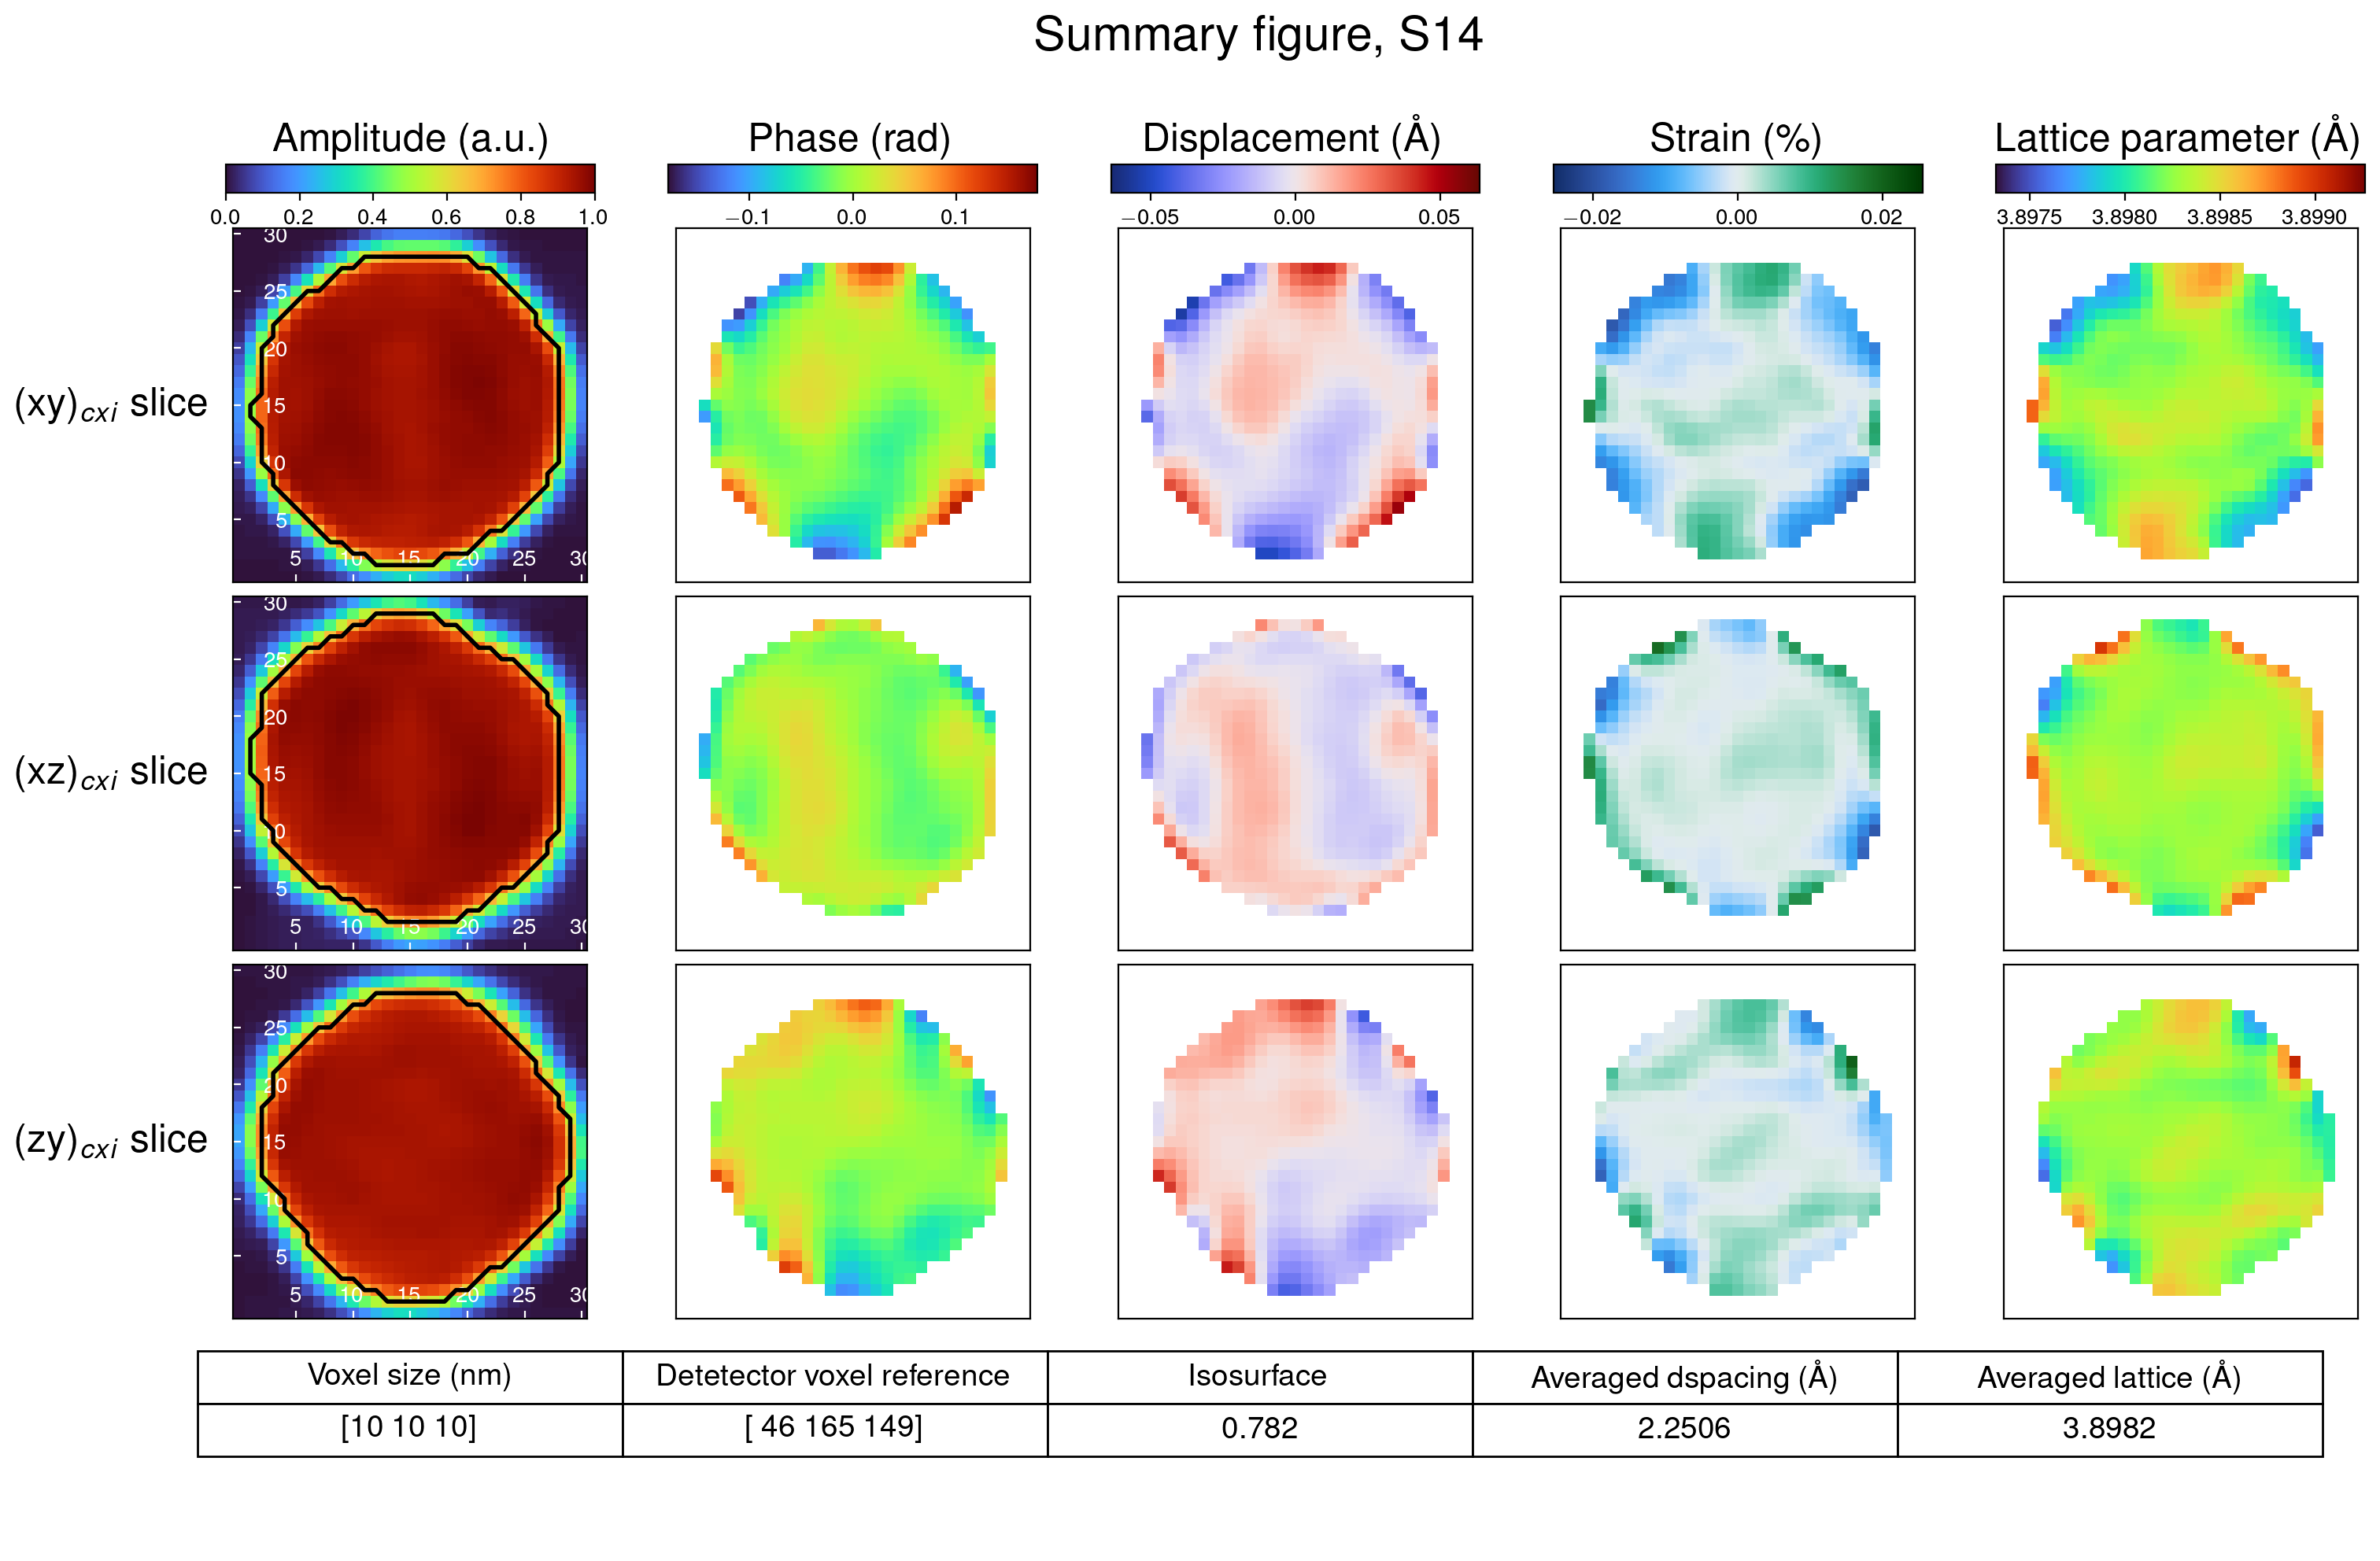

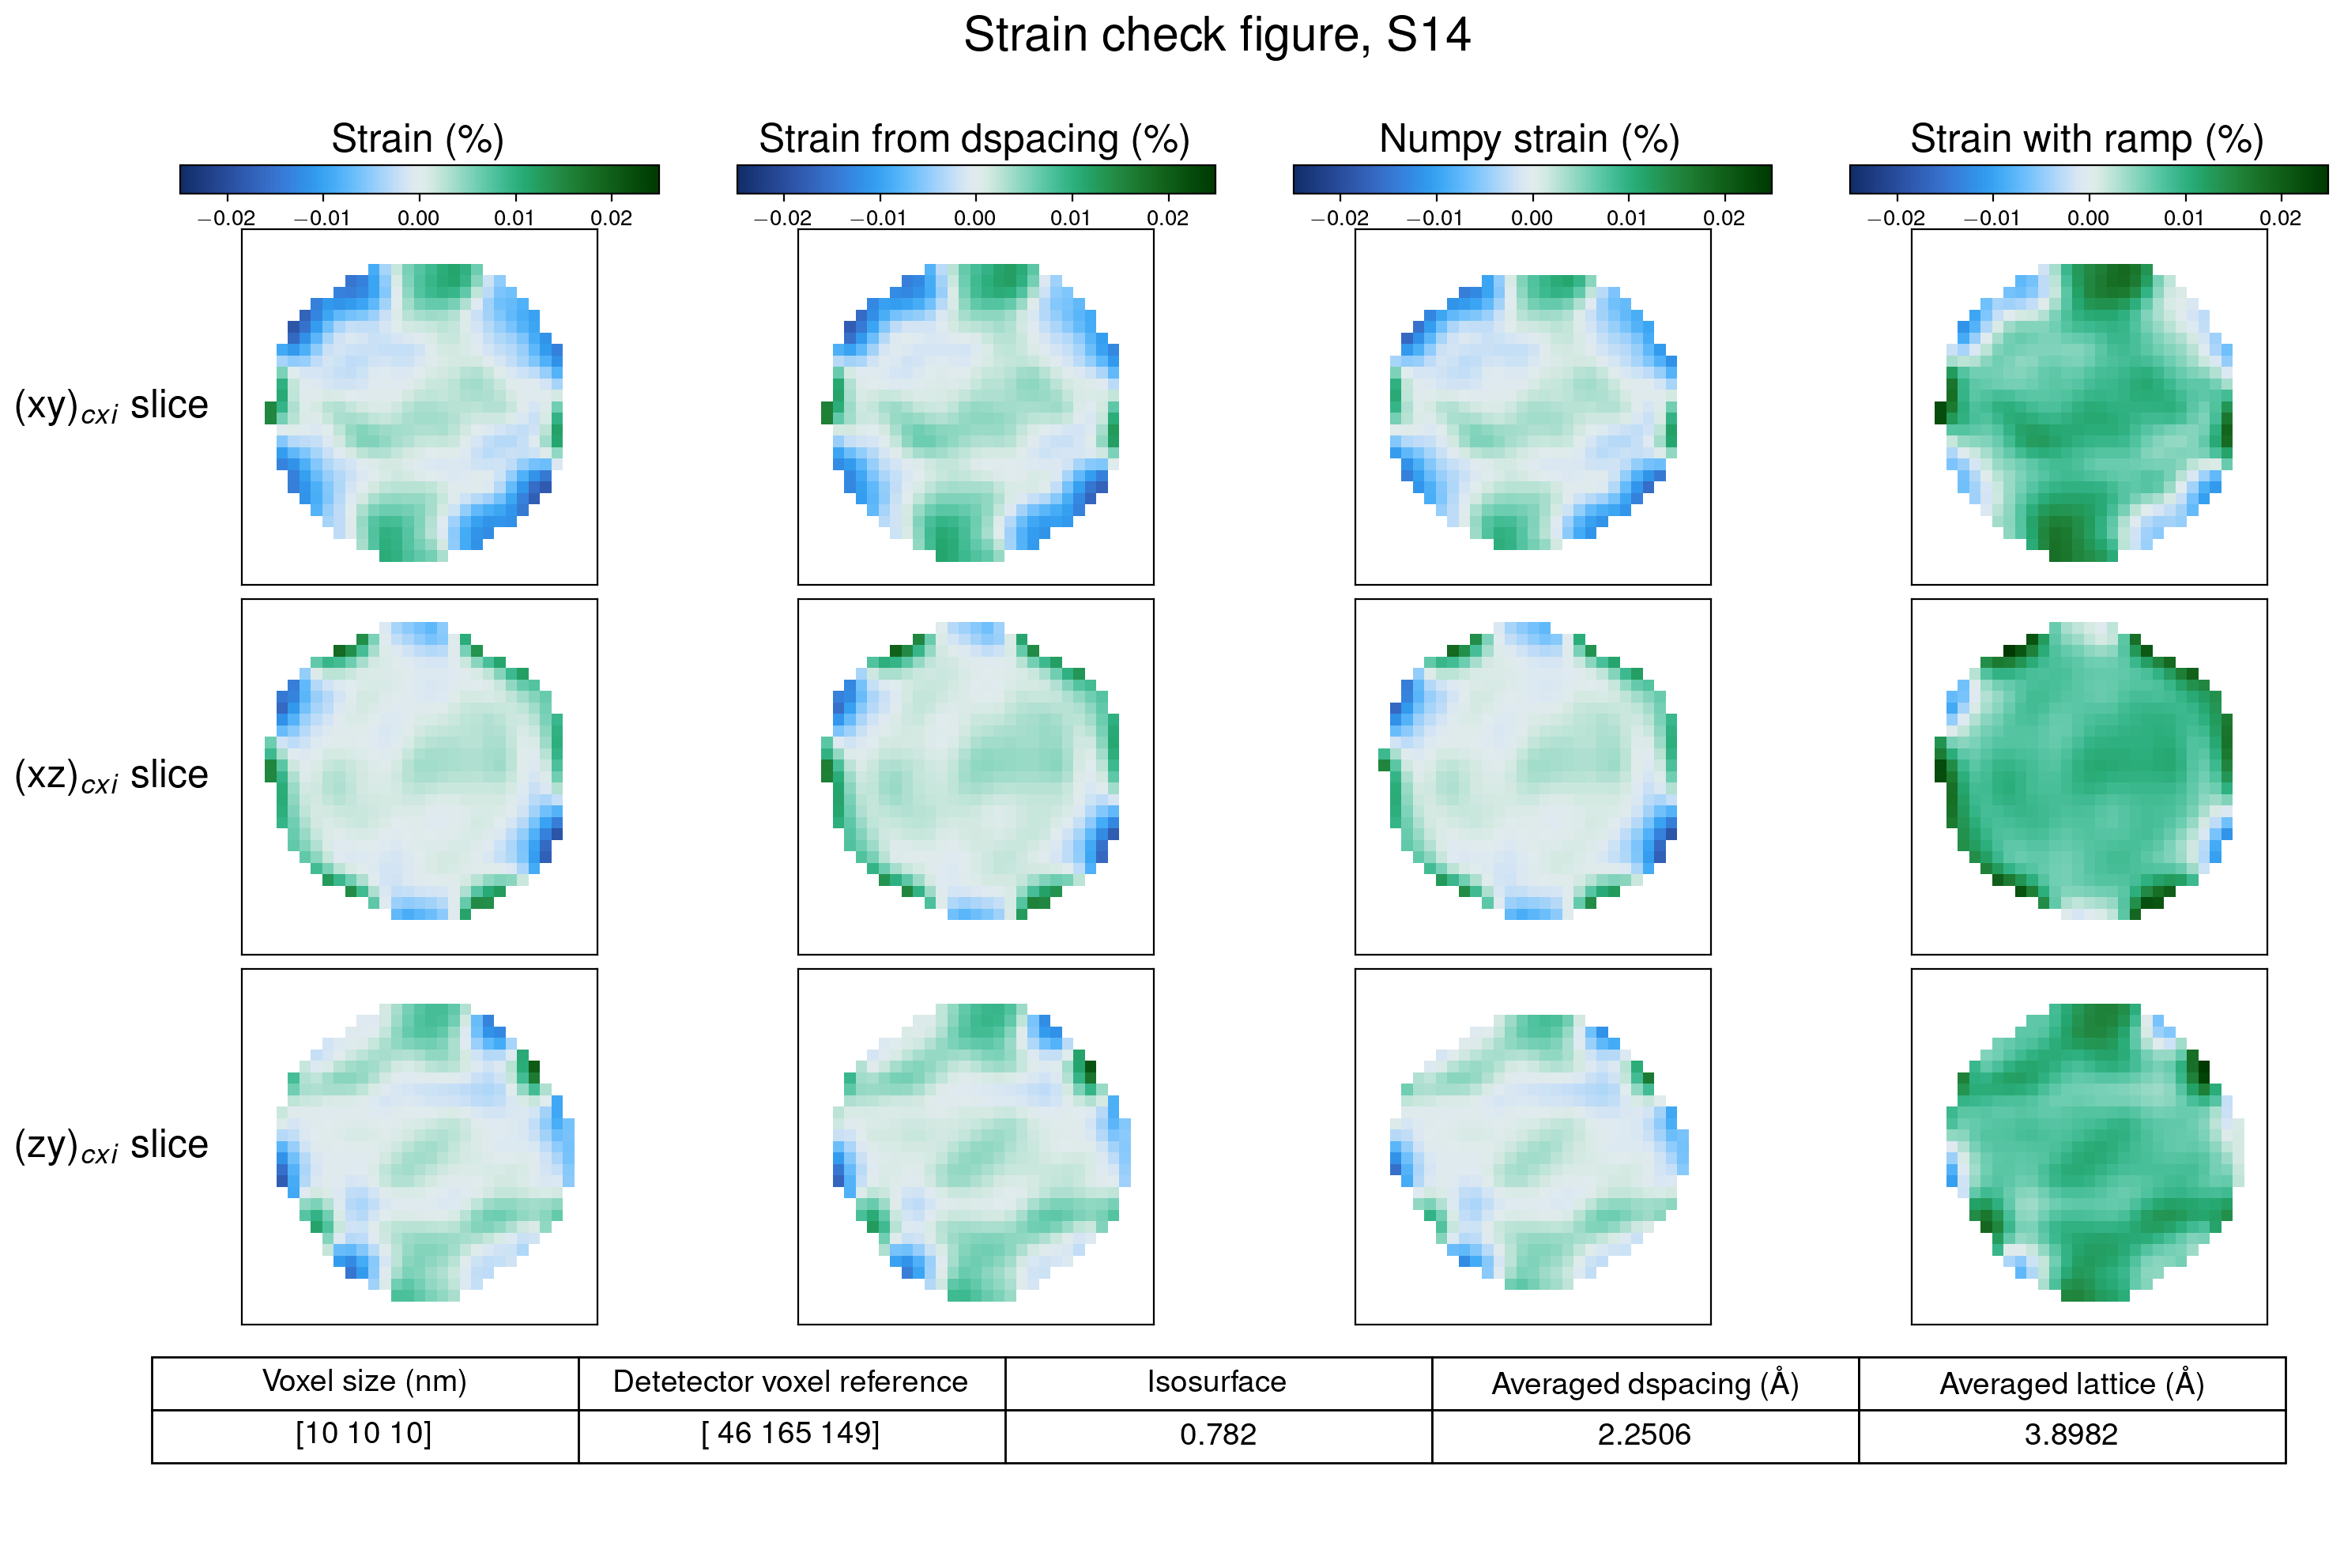

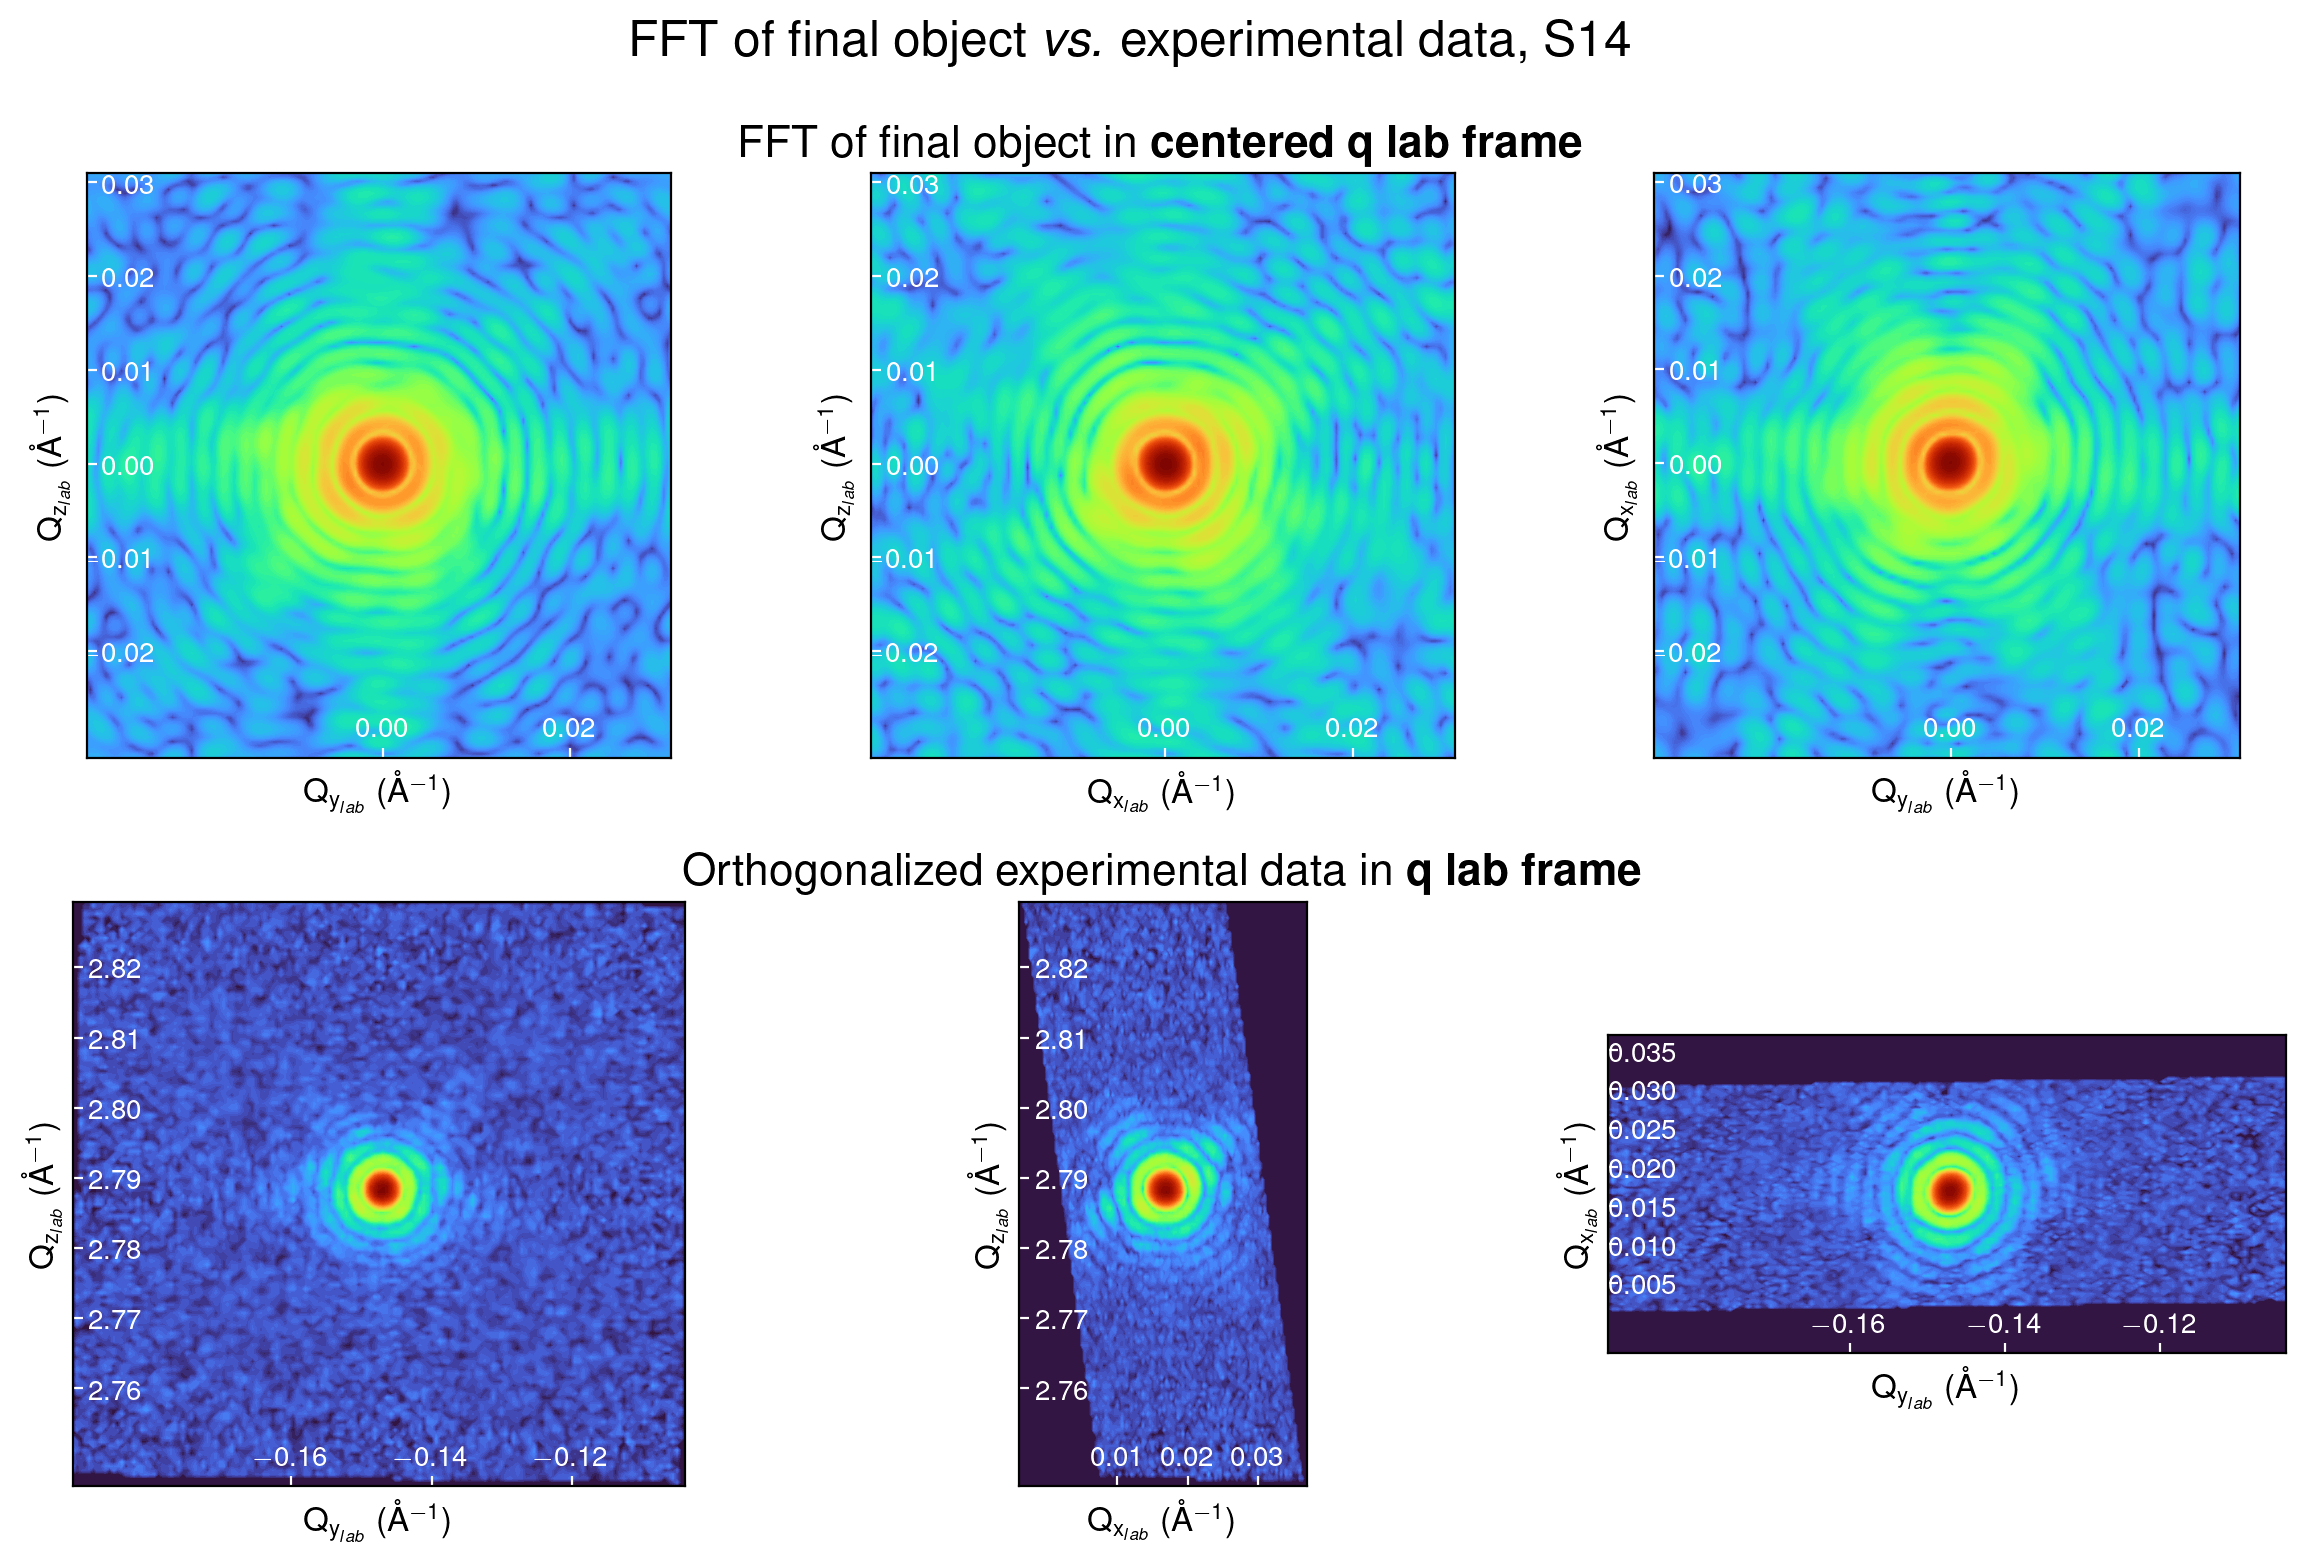


********************************************************************************
*Saving scan parameter file at the following location: /data/id01/inhouse/clatlan
/experiments/ch6347/2023s_analysis/results/Sample1_ParticlesMNOP/S14/*
********************************************************************************



In [7]:
bcdi_pipeline.postprocess()